# Price Predictor Parameter Optimisation

In [1]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as prep
import src.pipeline.predictors as predictors
from src.pipeline.predictors import LSTMPredictor

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal, Union

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

In [2]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_price_downloads"
MINUTELY_PRICES = DATA / "minutely_price_downloads"
INTERPOLATED_PRICES = DATA / "interpolated_prices"

SAVED_MODELS = DATA / "saved_models"

## Parametrisation Short-Term - a2

In [ ]:
a2_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=10,
                                                       sampling_rate_minutes=15,
                                                       price_csv_path=INTERPOLATED_PRICES / "2025-05-19 23_13_53  DAX Close Interpolated Prices at 15min from 2016-07-01 to 2025-04-30.csv",
                                                       daily_prediction_hour=16,
                                                       predict_before_daily_prediction_hour=False,
                                                       rolling_window_size=32,
                                                       forecast_horizon=16,
                                                       batch_size=64,
                                                       model_save_directory=SAVED_MODELS / "predictor_a2",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[64, 128, 256],
                                                       n_lstm_layers_set=[2, 3, 4],
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[True, False],
                                                       use_final_hidden_state_set=[True, False],
                                                       dropout_set=[.3, .4],
                                                       )
a2_results

## Parametrisation Mid-Term - b1

In [3]:
b1_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=10,
                                                       sampling_rate_minutes=60,
                                                       price_csv_path=INTERPOLATED_PRICES / "2025-05-15 10_15_13  DAX Close Interpolated Prices at 60min from 2017-07-03 to 2025-04-30.csv",
                                                       daily_prediction_hour=20,
                                                       predict_before_daily_prediction_hour=True,
                                                       rolling_window_size=68,
                                                       forecast_horizon=14,
                                                       batch_size=64,
                                                       model_save_directory=SAVED_MODELS / "predictor_b1",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[64, 128, 256],
                                                       n_lstm_layers_set=[2, 3, 4],
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[True, False],
                                                       use_final_hidden_state_set=[True, False],
                                                       dropout_set=[.3, .4],
                                                       )
b1_results

Train loss: 0.7914489479735494 | Val Loss: 4.630210667848587  | Patience 0/40 | LRate: 0.001 | Progress: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]
Train loss: 0.7700181305408478 | Val Loss: 4.301094710826874  | Patience 0/40 | LRate: 0.001 | Progress: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]
Train loss: 0.9847717098891735 | Val Loss: 3.876889407634735  | Patience 0/40 | LRate: 0.001 | Progress: 100%|██████████| 2/2 [00:06<00:00,  3.15s/it]
Train loss: 0.9663152638822794 | Val Loss: 4.420013427734375  | Patience 0/40 | LRate: 0.001 | Progress: 100%|██████████| 2/2 [00:13<00:00,  6.68s/it]


,Hidden Layer Size,N. LSTM Layers,Loss Weight Range,Pre-LSTM FC Layer,Final Hidden State,Dropout,Train Loss,Val Loss
2,64,2,"(1, 0.7)",True,False,0.3,0.984772,3.876889
1,64,2,"(1, 0.7)",True,True,0.4,0.770018,4.301095
3,64,2,"(1, 0.7)",True,False,0.4,0.966315,4.420013
0,64,2,"(1, 0.7)",True,True,0.3,0.791449,4.630211


## Parametrisation Long-Term - c1


In [ ]:
c1_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=10,
                                                       sampling_rate_minutes=60 * 14,  # one day from 8am to 22pm
                                                       price_csv_path=INTERPOLATED_PRICES / "2025-05-21 13_50_02  DAX Close Interpolated Prices at 1d from 2016-07-01 to 2025-04-29.csv",
                                                       daily_prediction_hour=20,
                                                       predict_before_daily_prediction_hour=True,  # irrelevant
                                                       rolling_window_size=120,  # i.e. 6 months á 20 days
                                                       forecast_horizon=10,  # i.e. 2 weeks á 5 days
                                                       batch_size=64,
                                                       model_save_directory=SAVED_MODELS / "predictor_c1",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[64, 128, 256],
                                                       n_lstm_layers_set=[2, 3, 4],
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[True, False],
                                                       use_final_hidden_state_set=[True, False],
                                                       dropout_set=[.3, .4],
                                                       )
c1_results

## Run

In [77]:
AV_API_KEY_FILE = ROOT / "private" / "Alpha Vantage API Key.txt"
with open(AV_API_KEY_FILE) as file: AV_API_KEY = file.read()

sampling_rate_minutes = 15
ticker = 'Dax'

In [78]:
ts = TimeSeries(key=AV_API_KEY, output_format='pandas')
recent_dax = ts.get_intraday(ticker, interval=f'{sampling_rate_minutes}min',
                             outputsize="compact" if 14 * 60 / sampling_rate_minutes < 100 else "full")
daily_dax = recent_dax[0][recent_dax[0].index.day_of_year == recent_dax[0].index.day_of_year.max()][
    '4. close']  # last day
recent_price_data = prep.time_interpolation_new_sampling_rate(daily_dax, '4. close', 'date',
                                                              f'{sampling_rate_minutes}min',
                                                              manual_operating_hours=(8, 22))
recent_price_data

,close
date,
2025-05-16 08:00:00,43.48750
2025-05-16 08:15:00,43.24000
2025-05-16 08:30:00,42.92000
2025-05-16 08:45:00,42.84000
2025-05-16 09:00:00,42.76000
2025-05-16 09:15:00,42.78000
2025-05-16 09:30:00,42.80000
2025-05-16 09:45:00,42.87500
2025-05-16 10:00:00,42.89790


Prices are expected to go DOWN!


(array([31.8091462 , 31.8301834 , 31.85673586, 31.88494352, 31.91238934,
        31.93949301, 31.96582016, 31.99007451, 32.01100482, 32.02798444,
        32.04102383, 32.05052384, 32.05705088, 32.06117972, 32.06342963,
        32.06423025]),
 DatetimeIndex(['2025-05-16 16:00:00', '2025-05-16 16:15:00',
                '2025-05-16 16:30:00', '2025-05-16 16:45:00',
                '2025-05-16 17:00:00', '2025-05-16 17:15:00',
                '2025-05-16 17:30:00', '2025-05-16 17:45:00',
                '2025-05-16 18:00:00', '2025-05-16 18:15:00',
                '2025-05-16 18:30:00', '2025-05-16 18:45:00',
                '2025-05-16 19:00:00', '2025-05-16 19:15:00',
                '2025-05-16 19:30:00', '2025-05-16 19:45:00'],
               dtype='datetime64[ns]', freq='15min'))

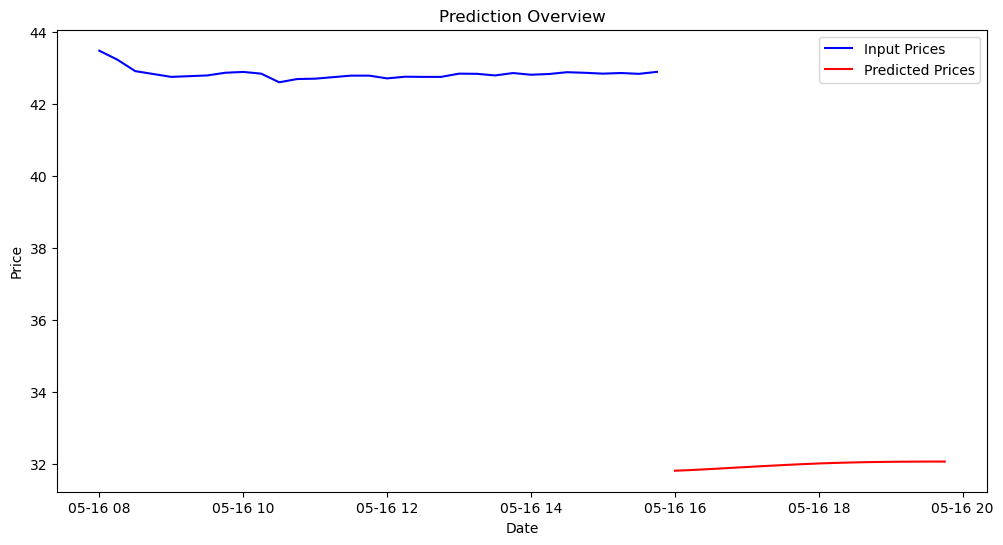

In [79]:
predictor_a2_1.predict(recent_price_data.iloc[:32])